## Testing the gaussian sampler gt.dynamics.NormalState()

Parameters of the multivariate normal distribution should be choosen carefully because the gibbs sampler implemented in graph-tool can run into numerical instabilities. In the following, some trials.

In [1]:
import scipy.sparse
import graph_tool.all as gt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### 2d case

- covariance parameter rho=cov(x1, x2)/sqrt(var(x1) * var(x2)) should be in interval [-0.3, +0.3]. At rho=0.3 the gaussian is already very smashed and for bigger values the sampler diverges. Even before it diverges, one can see that for increasing values the covariance matrix starts to diverge (try for example rho = 0.3, the covariance matrix has off-diag entries = +20!)

- the sampler seems to work only for positive correlation parameters. if a negative value of rho is provided, the resulting gaussian is still positive correlated! (see plot and numpy.cov() check)

In [52]:
size = 2

sigma = 1
rho = +0.15

#Precision matrix
W = np.ones((2,2)) * ( 1 / ((1-rho**2) * (sigma **2)) )
W[0, 1]*= (- rho)
W[1,0]*= (- rho)
print("Precision matrix", W)

g = gt.Graph((scipy.sparse.lil_matrix(W)), directed=False)

eigenvalues = np.linalg.eigvals(W)
re_eigenvalues = np.real(eigenvalues)
lmax = max(re_eigenvalues)

print(f"leading eigenval = {lmax}")
print("symmetric:", np.allclose(W, W.T))
print("rank: ", np.linalg.matrix_rank(W))

Precision matrix [[ 1.0230179  -0.15345269]
 [-0.15345269  1.0230179 ]]
leading eigenval = 1.1764705882352942
symmetric: True
rank:  2


all valid values: True


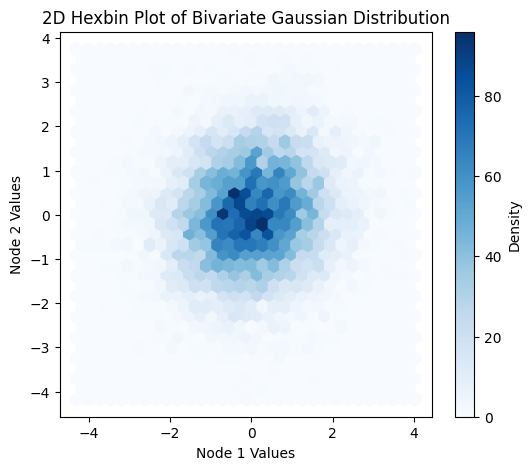

Estimated Mean: [0.01510241 0.02091345]
Estimated Covariance Matrix: [[1.1791765  0.12643545]
 [0.12643545 1.16248505]]
Real Covariance Matrix: [[1.   0.15]
 [0.15 1.  ]]


In [53]:
M = 10000
istate = gt.NormalState(g, w= W[0,1], sigma = sigma) 
# a node sstd too large can cause invalid values. i dont know why but that is.
X = []
for m in range(M):
    istate.iterate_sync()
    X.append(istate.get_state().a.copy())
X = np.array(X).T # N rows, M columns
# Check for invalid values
print(f"all valid values: {np.isfinite(X).all()}")

plt.figure(figsize=(6, 5))
plt.hexbin(X[0, :], X[1,], gridsize=30, cmap='Blues')
plt.colorbar(label='Density')
plt.title('2D Hexbin Plot of Bivariate Gaussian Distribution')
plt.xlabel('Node 1 Values')
plt.ylabel('Node 2 Values')
plt.show()

# 1. Fit the bivariate Gaussian
mean_fit = np.mean(X, axis=1)  # Estimated mean
cov_fit = np.cov(X)  # Estimated covariance matrix
real_cov = np.linalg.inv(W)

# Display the fitted parameters
print("Estimated Mean:", mean_fit)
print("Estimated Covariance Matrix:", cov_fit)
print("Real Covariance Matrix:", real_cov)

In [55]:
m = M

if M > X.shape[1]:
    raise ValueError(f'M ({m}) is larger than the number of available columns ({X.shape[1]})')
selected_samples = np.arange(X.shape[1]- m , X.shape[1])
X = X[:, selected_samples]

state = gt.PseudoNormalBlockState(X)
for i in range(5):
    delta, *_ = state.mcmc_sweep(niter=1, verbose=False)
    print(delta)
u = state.get_graph()      # reconstructed network
w_r = state.get_x()        # reconstructed weights

metadata = {
    'nodes': u.num_vertices(),
    'edges': u.num_edges(),
    'samples': m,
    #'jaccard_unweighted': gt.similarity(g, u),
    #'jaccard_weighted': gt.similarity(g, u, g.edge_properties.weights, w_r)
}
print(metadata)

print("Estimated precision entry :", w_r.a)
print("Real precision entry :", W[0,1])

-228.3360088302119
-0.6838585527052511
-0.00035595961245959984
-2.0011220214222192e-07
0.0
{'nodes': 2, 'edges': 1, 'samples': 10000}
Estimated precision entry : [-0.09329619]
Real precision entry : -0.1534526854219949


## higher dimension (but not too high)

Valid values in time series, but algorithm is not able to infer the network

In [137]:
size = 4

sigma = 0.1
rho = 1

#Precision matrix
# im not following any formula here
W = np.zeros((size, size))
for i in range(size):
    W[i,i] = (sigma**2 )/ 2

W[1, 2] = np.random.choice([-1 ,0, +1]) * rho

W[0, 3] = np.random.choice([-1 ,0, +1]) * rho

W += W.T
print("Precision matrix:", W)

eigenvalues = np.linalg.eigvals(W)
re_eigenvalues = np.real(eigenvalues)
lmax = max(re_eigenvalues)

print(f"leading eigenval = {lmax}")
print("rank: ", np.linalg.matrix_rank(W))

if np.linalg.matrix_rank(W) == size:
    g = gt.Graph((scipy.sparse.lil_matrix(W)), directed=False)


Precision matrix: [[ 0.01  0.    0.    1.  ]
 [ 0.    0.01 -1.    0.  ]
 [ 0.   -1.    0.01  0.  ]
 [ 1.    0.    0.    0.01]]
leading eigenval = 1.01
rank:  4


all valid values: True


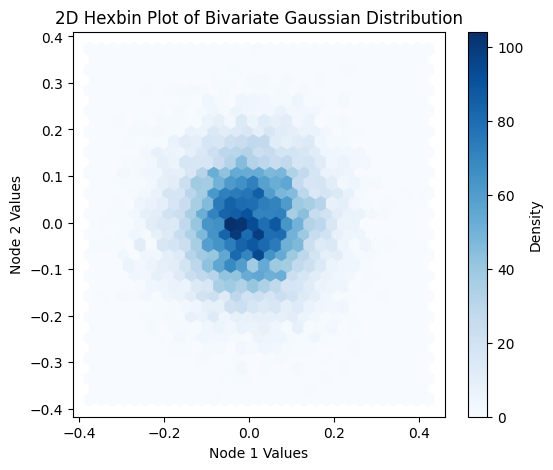

In [138]:
M = 10000
istate = gt.NormalState(g, w= g.ep.weight, sigma = sigma) 
# a node sstd too large can cause invalid values. i dont know why but that is.
X = []
for m in range(M):
    istate.iterate_sync()
    X.append(istate.get_state().a.copy())
X = np.array(X).T # N rows, M columns
# Check for invalid values
print(f"all valid values: {np.isfinite(X).all()}")

plt.figure(figsize=(6, 5))
plt.hexbin(X[0, :], X[3,], gridsize=30, cmap='Blues')
plt.colorbar(label='Density')
plt.title('2D Hexbin Plot of Bivariate Gaussian Distribution')
plt.xlabel('Node 1 Values')
plt.ylabel('Node 2 Values')
plt.show()

In [139]:
m = M

if M > X.shape[1]:
    raise ValueError(f'M ({m}) is larger than the number of available columns ({X.shape[1]})')
selected_samples = np.arange(X.shape[1]- m , X.shape[1])
X = X[:, selected_samples]

state = gt.PseudoNormalBlockState(X)
for i in range(5):
    delta, *_ = state.mcmc_sweep(niter=1, verbose=False)
    print(delta)
u = state.get_graph()      # reconstructed network
w_r = state.get_x()        # reconstructed weights

metadata = {
    'nodes': u.num_vertices(),
    'edges': u.num_edges(),
    'samples': m,
    #'jaccard_unweighted': gt.similarity(g, u),
    #'jaccard_weighted': gt.similarity(g, u, g.edge_properties.weights, w_r)
}
print(metadata)

print("Estimated precision matrix :", w_r.a)

-72331.34655022895
0.0
0.0
0.0
0.0
{'nodes': 4, 'edges': 0, 'samples': 10000}
Estimated precision matrix : []
